In [1]:
import time
#import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
#import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
import pandas as pd

from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 
import pandas as pd
from skimage.transform import AffineTransform, warp
from skimage.transform import rotate as rotate_transform
from skimage.util import random_noise
from skimage.filters import gaussian
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
torch.cuda.empty_cache()



#https://github.com/princeton-vl/pytorch_stacked_hourglass/blob/master/data/MPII/dp.py
#import cv2
import sys
import os
import torch
import numpy as np
import torch.utils.data
#import utils.img

class GenerateHeatmap():
    def __init__(self, output_res, num_parts):
        self.output_res = output_res
        self.num_parts = num_parts
        sigma = self.output_res/64
        self.sigma = sigma
        size = 6*sigma + 3
        x = np.arange(0, size, 1, float)
        y = x[:, np.newaxis]
        x0, y0 = 3*sigma + 1, 3*sigma + 1
        self.g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

    def __call__(self, keypoints):
        hms = np.zeros(shape = (self.num_parts, self.output_res, self.output_res), dtype = np.float32)
        sigma = self.sigma
        for p in keypoints:
            for idx, pt in enumerate(p):
                #print(pt)
                if pt[0] > 0: 
                    x, y = int(pt[0]), int(pt[1])
                    if x<0 or y<0 or x>=self.output_res or y>=self.output_res:
                        continue
                    ul = int(x - 3*sigma - 1), int(y - 3*sigma - 1)
                    br = int(x + 3*sigma + 2), int(y + 3*sigma + 2)

                    c,d = max(0, -ul[0]), min(br[0], self.output_res) - ul[0]
                    a,b = max(0, -ul[1]), min(br[1], self.output_res) - ul[1]

                    cc,dd = max(0, ul[0]), min(br[0], self.output_res)
                    aa,bb = max(0, ul[1]), min(br[1], self.output_res)
                    hms[idx, aa:bb,cc:dd] = np.maximum(hms[idx, aa:bb,cc:dd], self.g[a:b,c:d])
        return hms

def create_heatmap(output_size, landmarks):
    hms = np.zeros(shape = (11, 224, 224), dtype = np.float32)
    for i in range(11):
        landmark = landmarks[i]
        pos = np.dstack(np.mgrid[0:224:1, 0:224:1])
        rv = multivariate_normal(mean=[landmark[1].item(), landmark[0].item()], cov=10)
        hms[i,:,:] = rv.pdf(pos)
    hms = TF.to_tensor(hms)
    return hms

class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, params):

        angle = params['rotation_range'][0]
        angle = (random.uniform(0,1))*random.choice([-1,1])*angle
        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = rotate_transform(np.array(image), angle = angle, mode = 'edge')

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5

        # PIL expects RGB images to be uint with ranges from 0 to 255 so we have to convert it to a type that PIL can excpect ie a uint from 0 to 255 
        return Image.fromarray((image * 255).astype(np.uint8)), new_landmarks

    def translation(self, image, landmarks, params):
        image_shape = np.array(image).shape
        ty = random.uniform(params['height_shift_range'][0]*image_shape[0],          
                            params['height_shift_range'][1]*image_shape[0])
        tx = random.uniform(params['width_shift_range'][0]*image_shape[1],
                            params['width_shift_range'][1]*image_shape[1] )

        
        horizontal_shift =  tx*random.choice([-1,1])
        vertical_shift = ty*random.choice([-1,1])
        horizontal_shift_normalised = horizontal_shift/image_shape[1]
        vertical_shift_normalised =  vertical_shift/image_shape[0]

        transform = AffineTransform(translation=(-horizontal_shift,-vertical_shift))

        image = warp(np.array(image),transform,mode='edge')

        landmarks = landmarks + torch.tensor([horizontal_shift_normalised,vertical_shift_normalised])
  
        # PIL expects RGB images to be uint with ranges from 0 to 255 so we have to convert it to a type that PIL can excpect ie a uint from 0 to 255 
        return Image.fromarray((image * 255).astype(np.uint8)), landmarks
        
    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def zoom(self, image, landmarks, params):

        landmarks = landmarks.astype(int)
        img_shape = np.array(image).shape
        zoom = random.uniform(params['zoom_range'][0],params['zoom_range'][1])
        image = TF.resize(image,(int(img_shape[0]*zoom), int(img_shape[1]*zoom)) )
        scale_transform = torch.tensor([[zoom, 0], 
                                        [0, zoom]])
        landmarks = np.matmul(landmarks, scale_transform).float()
        new_img_shape = np.array(image).shape
        landmarks = landmarks / torch.tensor([new_img_shape[1], new_img_shape[0]])
        
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks
    


    def __call__(self, image, landmarks, params):

        # set checked image and landmark to landmark_ and image_ (this is for making sure we use the last checked tranformed instead of wrongly tranformed to do the following               # tranform)
        
        # -----------------------
        image_ = Image.fromarray(image.copy())
        landmarks_ = landmarks.copy()
        # -----------------------

        # ZOOM
        image , landmarks = self.zoom(image_, landmarks_, params)
        
        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        # correct this becuase hight and with is different sizes # NOTE fix
        landmarks_outofbounds = landmarks*image_shape[1]  > image_shape[1]  
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.zoom(image_, landmarks_, params)
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1]  > image_shape[1] 

        # ----------------------
        image_ = image
        landmarks_ = landmarks
        # ----------------------

        # RESIZE
        image, landmarks = self.resize(image_, landmarks_, (224, 224))
        
        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.resize(image_, landmarks_, (224, 224))
            image_shape = np.array(image).shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1]  > image_shape[1] 
        landmarks_ = landmarks
        image_ = image

        # ----------------------
        #image_, landmarks_ = self.color_jitter(image_, landmarks_)
        # ----------------------
        
        # ROTATE
        image, landmarks = self.rotate(image_, landmarks_, params)
        
        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.rotate(image_, landmarks_, params)
            image_shape = np.array(image).shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 


        # ----------------------
        landmarks_ = landmarks
        image_ = image
        # ----------------------

        # TRANSLATION
        image, landmarks = self.translation(image, landmarks, params)

        image_shape = np.array(image).shape
        landmarks_bool = landmarks < 0
        landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 
        while landmarks_bool.any() or landmarks_outofbounds.any():
            image, landmarks = self.translation(image_, landmarks_, params)
            image_shape = np.array(image).shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*image_shape[1] > image_shape[1] 


        # ----------------------
        landmarks_ = landmarks
        image_ = image
        # ----------------------
 
        
        image = TF.to_tensor(image)
        # the following tranform normalises each channel to have a mean at 0.5 and std of 0.5 / NOTE: NOT sure if this is theoreticlly better, should check this
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks


class LandmarksDataset():

    def __init__(self, transform=None,zoom = [1.0 - 0.03258157476873315, 1.0 + 0.03258157476873315], rotation = [22], height_shift= [0,0.03003200603616672], width_shift= [0,0.03003200603616672 ]):

        df = pd.read_csv('C:/Projects/msc_haar/tsetsedata_2019_left_commas/annotations_left.txt',index_col=0, header=None)

        df2 =  pd.read_csv('C:/Projects/msc_haar/flipped_left.csv', index_col= 0)
        self. tranform = transform
        self.zoom = zoom
        self.rotation = rotation
        self.height_shift = height_shift
        self.width_shift = width_shift
        self.image_filenames = []
        self.landmarks = []
        self.transform = transform
        self.image_dir = 'C:/Projects/msc_haar/tsetsedata_2019_left_commas/images_left/'
        self.image_dir2 = 'C:/Projects/msc_haar/tsetsedata_2019_right_commas/flipped_left/'
        self.TransF_ = True

       # ------------------- Append left wings data to dataset class ------------

        for filename in df.index[:]:
            self.image_filenames.append(os.path.join(self.image_dir, filename))
            

            landmarks = []
            for num in range(1, 23, 2):
                
                x_coordinate = df.loc[filename,num] - 1
                y_coordinate = df.loc[filename, num+1] - 1
                landmarks.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmarks)
        

        assert len(self.image_filenames) == len(self.landmarks)

        # ------------------ Append flipped right wings data to dataset class-----


        for filename in df2.index[:]:

            self.image_filenames.append(os.path.join(self.image_dir2, filename))

            landmarks = []
            for num in range(1, 23, 2):
                x_coordinate = df2.loc[filename,'{}'.format(num)] +1
                y_coordinate = df2.loc[filename, '{}'.format(num+1)] +1
                landmarks.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmarks)
        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

        # ----------------------

    def TransF(self):
        self.TransF_ = True
    def NoTransF(self):
        self.TransF_ = False
    def set_params(self, zoom = [0.95, 0.105], rotation = [10], height_shift= [0,0.05], width_shift= [0,0.05]):
        self.zoom = zoom
        self.rotation = rotation
        self.height_shift = height_shift
        self.width_shift = width_shift
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        params = {'zoom_range': self.zoom, 'rotation_range':self.rotation, 'height_shift_range': self.height_shift, 'width_shift_range': self.width_shift }
        image_name = self.image_filenames[index]
        image_ = plt.imread(image_name)
        landmarks_ = self.landmarks[index]
        image = plt.imread(self.image_filenames[index])
    
        landmarks = self.landmarks[index]
        
        if self.transform and self.TransF_:
            
            image, landmarks = self.transform(image_, landmarks_, params)
            image_shape = image.shape
            landmarks_bool = landmarks < 0
            landmarks_outofbounds = landmarks*224 > image_shape[1] 
            while landmarks_bool.any() or landmarks_outofbounds.any():
                image, landmarks = self.transform(image_, landmarks_, params)
                landmarks_bool = landmarks < 0
                landmarks_outofbounds = landmarks*224 > image_shape[1] 
        else:
            img_shape = image.copy().shape
            image = Image.fromarray(image)
            image = TF.resize(image, (224,224))
            landmarks = torch.tensor(landmarks) / torch.tensor([img_shape[1],img_shape[0]])
            image = TF.to_tensor(image)
            # the following tranform normalises each channel to have a mean at 0.5 and std of 0.5 / NOTE: NOT sure if this is theoreticlly better, should check this
            image = TF.normalize(image, [0.5], [0.5])


        landmarks = torch.tensor(landmarks) - 0.5
        landmarks_ = (landmarks + 0.5) * torch.tensor([224, 224])
        hms = create_heatmap(224, landmarks_ )
        hms = hms.permute(1, 2, 0)#.unsqueeze(0)
        
        return image, hms,landmarks,  image_name


dataset = LandmarksDataset(Transforms())

In [2]:


class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

'''
You instantiate it with the same arguments used for the normalize. and then use it the same way

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
unorm(tensor)

'''

'\nYou instantiate it with the same arguments used for the normalize. and then use it the same way\n\nunorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))\nunorm(tensor)\n\n'

In [3]:
import torch.nn as nn
class fcn_resnet50(nn.Module):
    def __init__(self,num_classes=22):
        super().__init__()
        self.model_name='fcn_resnet50'
        self.model=models.segmentation.fcn_resnet50(pretrained=False)
        self.model.classifier[4]=nn.Conv2d(512, 11, kernel_size=(1,1), stride=(1,1))
        
    def forward(self, x):
        x=self.model(x)['out']
        return x


def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [4]:
dataset.NoTransF()
#DataSet.resize(244)

# split the dataset into validation and test sets
len_valid_test_set = int(0.2*len(dataset)) # 60% training, 20% validation, 20% testing

len_train_set = len(dataset) - len_valid_test_set*2

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_test_set))
print("The length of Valid set is {}".format(len_valid_test_set))

train_dataset , valid_dataset, test_dataset  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_test_set, len_valid_test_set], generator=torch.Generator().manual_seed(42))

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=15, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=15, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=None,batch_sampler=None, shuffle=False)

The length of Train set is 1452
The length of Valid set is 484
The length of Valid set is 484


In [5]:
resnet50f = ResNetUNet(11)
resnet50f.load_state_dict(torch.load('C:/Projects/msc_haar/manuscript1_exp/regressors/models/model_resnet50_UNET_finetune_0_s0.pth'))
resnet50f.cpu()

ResNetUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [50]:
import cv2
def get_coordinates_from_heatmap(predictions):
    coords = []
    for i in range(predictions.size()[1]):
            (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(predictions[0][i].detach().numpy())
            coords.append(list(maxLoc))
    coords = np.array(coords)
    coords = TF.to_tensor(coords)
    return(coords)


In [101]:
def get_average_coord(hm_preds):

    coords = get_coordinates_from_heatmap(hm_preds.unsqueeze(0))
    #print(coords)
    #hm_preds = hm_preds.unsqueeze(0)
    avg_coords = []
    for i in range(len(hm_preds)):
        coord = coords[0][i]
        centre = hm_preds[i][coord[1], coord[0]]
        up = hm_preds[i][coord[1]+1, coord[0]]
        down = hm_preds[i][coord[1]-1, coord[0]]
        left = hm_preds[i][coord[1], coord[0]-1]
        right = hm_preds[i][coord[1], coord[0]+1]
        top_left = hm_preds[i][coord[1]+1, coord[0]-1]
        top_right = hm_preds[i][coord[1]+1, coord[0]+1]
        bottom_left = hm_preds[i][coord[1]-1, coord[0]-1]
        bottom_right = hm_preds[i][coord[1]-1, coord[0]+1]
        SUM = centre + up + down + left + right + bottom_left + bottom_right + top_left + top_right
        average_X_coord = (coord[0]*(centre/SUM)) +(coord[0]*(up/SUM)) + (coord[0]*(down/SUM)) + ((coord[0]+1)*(right/SUM)) + ((coord[0]+1)*(top_right/SUM)) + ((coord[0]+1)*(bottom_right/SUM)) +  ((coord[0]-1)*(left/SUM)) + ((coord[0]-1)*(bottom_left/SUM)) + ((coord[0]-1)*(top_left/SUM))
        average_Y_coord = (coord[1]*(centre/SUM)) +(coord[1]*(up/SUM)) + (coord[1]*(down/SUM)) + ((coord[1]+1)*(right/SUM)) + ((coord[1]+1)*(top_right/SUM)) + ((coord[1]+1)*(bottom_right/SUM)) +  ((coord[1]-1)*(left/SUM)) + ((coord[1]-1)*(bottom_left/SUM)) + ((coord[1]-1)*(top_left/SUM))
        #print(average_Y_coord.item())
        avg_coords.append([average_X_coord.item(), average_Y_coord.item()])
    avg_coords = np.array(avg_coords)
    avg_coords = TF.to_tensor(avg_coords)
    return avg_coords
        

images, hm, landmark, filename = dataset[0]
landmarks224 = (landmark + 0.5)*torch.tensor([224, 224])
#hm = GenerateHeatmap(224,11)
#hm = TF.to_tensor(hm(landmarks224.unsqueeze_(0))).permute(1, 2, 0)
print(get_average_coord(hm))

tensor([[[177.0061,  45.0061],
         [130.9953,  69.9953],
         [ 44.0243, 137.0244],
         [ 32.9717, 154.9717],
         [122.9867,  94.9867],
         [ 30.0136, 162.0136],
         [ 88.9975, 145.9975],
         [113.9749, 152.9749],
         [182.9910,  84.9910],
         [119.0254, 104.0254],
         [163.9814,  77.9814]]], dtype=torch.float64)
<ipython-input-1-3a046368fcaa>:341: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  landmarks = torch.tensor(landmarks) - 0.5


<ipython-input-1-3a046368fcaa>:341: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  landmarks = torch.tensor(landmarks) - 0.5
tensor([177.0928,  45.0054])
landmarks 224 tensor([[177.0928,  45.0054],
        [130.9289,  69.5956],
        [ 44.3715, 136.8087],
        [ 32.5682, 154.5136],
        [122.7978,  94.5136],
        [ 30.2076, 161.7267],
        [ 88.9617, 145.6611],
        [113.6174, 153.2021],
        [182.8633,  84.6775],
        [119.3879, 104.0218],
        [163.7158,  78.4480]])
landmarks full tensor([[1011.9590,  205.7389],
        [ 748.1652,  318.1511],
        [ 253.5515,  625.4110],
        [ 186.1042,  706.3478],
        [ 701.7014,  432.0621],
        [ 172.6148,  739.3220],
        [ 508.3525,  665.8794],
        [ 649.2424,  700.3525],
        [1044.9333,  387.0972],
        [ 682.2167,  475.5281],
        [ 935.5

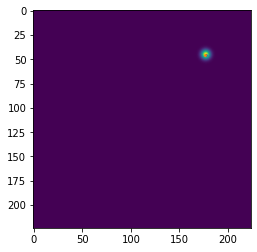

pred coord 224 tensor([[[175.9971,  44.9971],
         [129.9935,  68.9935],
         [ 43.0077, 136.0077],
         [ 31.9827, 152.9828],
         [121.9823,  93.9823],
         [ 28.9823, 160.9823],
         [ 87.9814, 144.9814],
         [112.9949, 151.9949],
         [181.0229,  84.0229],
         [118.9800, 103.9800],
         [162.0206,  79.0206]]], dtype=torch.float64)
pred coord full tensor([[[1005.6977,  205.7010],
         [ 742.8200,  315.3988],
         [ 245.7581,  621.7493],
         [ 182.7586,  699.3498],
         [ 697.0419,  429.6335],
         [ 165.6133,  735.9193],
         [ 502.7509,  662.7721],
         [ 645.6852,  694.8339],
         [1034.4166,  384.1047],
         [ 679.8858,  475.3372],
         [ 925.8320,  361.2371]]], dtype=torch.float64)
max pred coord 224 tensor([[[176,  45],
         [130,  69],
         [ 43, 136],
         [ 32, 153],
         [122,  94],
         [ 29, 161],
         [ 88, 145],
         [113, 152],
         [181,  84],
         [1

In [122]:

        

images, hm, landmark, filename = dataset[0]

landmarks = (landmark + 0.5)*torch.tensor([1280, 1024])
landmarks224 = (landmark + 0.5)*torch.tensor([224, 224])
mps = create_heatmap(224, landmarks224)
plt.imshow(hm[0])
print(landmarks224[0])
plt.scatter(landmarks224[0][0], landmarks224[0][1], s=3)
#plt.show()
print('landmarks 224', landmarks224)
print('landmarks full', landmarks)

hm_coord_224 = get_average_coord(hm)
hm_coord_full = hm_coord_224*torch.tensor([1280/224, 1024/224])
print('hm_coord_224', hm_coord_224)
print('hm_full', hm_coord_full)
predictions = resnet50f(images.unsqueeze(0))
print(predictions.size())
pred_coord = get_average_coord(predictions[0])
max_pred_coord = get_coordinates_from_heatmap(predictions)
plt.scatter(pred_coord[0][0][0], pred_coord[0][0][1], s=3)
plt.show()
print('pred coord 224',pred_coord)
print('pred coord full', pred_coord*torch.tensor([1280/224, 1024/224]))
print('max pred coord 224',max_pred_coord)
print('max pred coord full', max_pred_coord*torch.tensor([1280/224, 1024/224]))

In [18]:
images, hm, landmark, filename = dataset[0]

landmarks = (landmark + 0.5)*torch.tensor([1280, 1024])
landmarks224 = (landmark + 0.5)*torch.tensor([224, 224])
#hm = GenerateHeatmap(224,11)
#hm = TF.to_tensor(hm(landmarks224.unsqueeze_(0))).permute(1, 2, 0)
print(hm.size())
hm_coord = get_coordinates_from_heatmap(hm.unsqueeze(0))
print(hm_coord)

        #landmarks = torch.tensor(landmarks) - 0.5
        #landmarks_ = (landmarks + 0.5) * torch.tensor([224, 224])
        #hm = GenerateHeatmap(224,11)
        #hm = TF.to_tensor(hm(landmarks_.unsqueeze_(0))).permute(1, 2, 0)#.unsqueeze(0)
def get_average_coord(predictions, coords, n_pixels):
    for i in range(len(predictions)):
        #hm = predictions[i]
        #plt.imshow(hm)
        coord = coords[0][i]
        print(coord)
        pos = np.dstack(np.mgrid[0:224:1, 0:224:1])
# hotspot at pixel (22, 43) with roughly 4-pixel radial spread
        rv = multivariate_normal(mean=[coord[1].item(), coord[0].item()], cov=10)
        plt.imshow(rv.pdf(pos))
        #coord = coords[0][i]
        plt.scatter(coord[0].item(),coord[1].item(), s= 2)
        plt.show()
        #print(coord[0].item())
        #max_ = hm[coord[0].item(),coord[1].item()]
        #print(max_)
get_average_coord(hm, landmarks224, 2)     

torch.Size([11, 224, 224])
tensor([[[177,  45],
         [131,  70],
         [ 44, 137],
         [ 33, 155],
         [123,  95],
         [ 30, 162],
         [ 89, 146],
         [114, 153],
         [183,  85],
         [119, 104],
         [164,  78]]], dtype=torch.int32)
tensor(177.0928)
<ipython-input-1-3a046368fcaa>:341: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  landmarks = torch.tensor(landmarks) - 0.5


IndexError: index 1 is out of bounds for dimension 0 with size 0

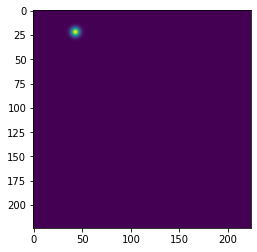

In [8]:
from scipy.stats import multivariate_normal

pos = np.dstack(np.mgrid[0:224:1, 0:224:1])
# hotspot at pixel (22, 43) with roughly 4-pixel radial spread
rv = multivariate_normal(mean=[22, 43], cov=10)
plt.imshow(rv.pdf(pos))

In [63]:
    def generate_target(self, joints, joints_vis):
        '''
        :param joints:  [num_joints, 3]
        :param joints_vis: [num_joints, 3]
        :return: target, target_weight(1: visible, 0: invisible)
        '''
        target_weight = np.ones((self.num_joints, 1), dtype=np.float32)
        target_weight[:, 0] = joints_vis[:, 0]

        assert self.target_type == 'gaussian', \
            'Only support gaussian map now!'

        if self.target_type == 'gaussian':
            target = np.zeros((self.num_joints,
                               self.heatmap_size[1],
                               self.heatmap_size[0]),
                              dtype=np.float32)

            tmp_size = self.sigma * 3

            for joint_id in range(self.num_joints):
                feat_stride = self.image_size / self.heatmap_size
                mu_x = int(joints[joint_id][0] / feat_stride[0] + 0.5)
                mu_y = int(joints[joint_id][1] / feat_stride[1] + 0.5)
                # Check that any part of the gaussian is in-bounds
                ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
                br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
                if ul[0] >= self.heatmap_size[0] or ul[1] >= self.heatmap_size[1] \
                        or br[0] < 0 or br[1] < 0:
                    # If not, just return the image as is
                    target_weight[joint_id] = 0
                    continue

                # # Generate gaussian
                size = 2 * tmp_size + 1
                x = np.arange(0, size, 1, np.float32)
                y = x[:, np.newaxis]
                x0 = y0 = size // 2
                # The gaussian is not normalized, we want the center value to equal 1
                g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * self.sigma ** 2))

                # Usable gaussian range
                g_x = max(0, -ul[0]), min(br[0], self.heatmap_size[0]) - ul[0]
                g_y = max(0, -ul[1]), min(br[1], self.heatmap_size[1]) - ul[1]
                # Image range
                img_x = max(0, ul[0]), min(br[0], self.heatmap_size[0])
                img_y = max(0, ul[1]), min(br[1], self.heatmap_size[1])

                v = target_weight[joint_id]
                if v > 0.5:
                    target[joint_id][img_y[0]:img_y[1], img_x[0]:img_x[1]] = \
                        g[g_y[0]:g_y[1], g_x[0]:g_x[1]]

        if self.use_different_joints_weight:
            target_weight = np.multiply(target_weight, self.joints_weight)

        return target, target_weight



In [62]:
def _gaussian(
        size=3, sigma=0.25, amplitude=1, normalize=False, width=None,
        height=None, sigma_horz=None, sigma_vert=None, mean_horz=0.5,
        mean_vert=0.5):
    # handle some defaults
    if width is None:
        width = size
    if height is None:
        height = size
    if sigma_horz is None:
        sigma_horz = sigma
    if sigma_vert is None:
        sigma_vert = sigma
    center_x = mean_horz * width + 0.5
    center_y = mean_vert * height + 0.5
    gauss = np.empty((height, width), dtype=np.float32)
    # generate kernel
    for i in range(height):
        for j in range(width):
            gauss[i][j] = amplitude * math.exp(-(math.pow((j + 1 - center_x) / (
                sigma_horz * width), 2) / 2.0 + math.pow((i + 1 - center_y) / (sigma_vert * height), 2) / 2.0))
    if normalize:
        gauss = gauss / np.sum(gauss)
    return gauss

def draw_gaussian(image, point, sigma):
    # Check if the gaussian is inside
    ul = [np.floor(np.floor(point[0]) - 3 * sigma),
          np.floor(np.floor(point[1]) - 3 * sigma)]
    br = [np.floor(np.floor(point[0]) + 3 * sigma),
          np.floor(np.floor(point[1]) + 3 * sigma)]
    if (ul[0] > image.shape[1] or ul[1] >
            image.shape[0] or br[0] < 1 or br[1] < 1):
        return image
    size = 6 * sigma + 1
    g = _gaussian(size)
    g_x = [int(max(1, -ul[0])), int(min(br[0], image.shape[1])) -
           int(max(1, ul[0])) + int(max(1, -ul[0]))]
    g_y = [int(max(1, -ul[1])), int(min(br[1], image.shape[0])) -
           int(max(1, ul[1])) + int(max(1, -ul[1]))]
    img_x = [int(max(1, ul[0])), int(min(br[0], image.shape[1]))]
    img_y = [int(max(1, ul[1])), int(min(br[1], image.shape[0]))]
    assert (g_x[0] > 0 and g_y[1] > 0)
    correct = False
    while not correct:
        try:
            image[img_y[0] - 1:img_y[1], img_x[0] - 1:img_x[1]
            ] = image[img_y[0] - 1:img_y[1], img_x[0] - 1:img_x[1]] + g[g_y[0] - 1:g_y[1], g_x[0] - 1:g_x[1]]
            correct = True
        except:
            print('img_x: {}, img_y: {}, g_x:{}, g_y:{}, point:{}, g_shape:{}, ul:{}, br:{}'.format(img_x, img_y, g_x, g_y, point, g.shape, ul, br))
            ul = [np.floor(np.floor(point[0]) - 3 * sigma),
                np.floor(np.floor(point[1]) - 3 * sigma)]
            br = [np.floor(np.floor(point[0]) + 3 * sigma),
                np.floor(np.floor(point[1]) + 3 * sigma)]
            g_x = [int(max(1, -ul[0])), int(min(br[0], image.shape[1])) -
                int(max(1, ul[0])) + int(max(1, -ul[0]))]
            g_y = [int(max(1, -ul[1])), int(min(br[1], image.shape[0])) -
                int(max(1, ul[1])) + int(max(1, -ul[1]))]
            img_x = [int(max(1, ul[0])), int(min(br[0], image.shape[1]))]
            img_y = [int(max(1, ul[1])), int(min(br[1], image.shape[0]))]
            pass
    image[image > 1] = 1
    return image


heatmap = np.zeros((11, 64, 64))
for i in range(11):
    #if landmarks224[i][0] > 0:
    heatmap[i] = draw_gaussian(heatmap[i], landmarks224[i]/4.0+1, 1)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

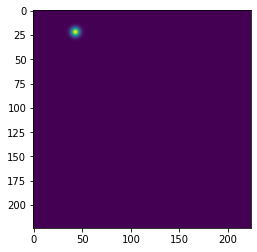

In [67]:
from scipy.stats import multivariate_normal

pos = np.dstack(np.mgrid[0:224:1, 0:224:1])
# hotspot at pixel (22, 43) with roughly 4-pixel radial spread
rv = multivariate_normal(mean=[22, 43], cov=10)
plt.imshow(rv.pdf(pos))

<ipython-input-1-3a046368fcaa>:341: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  landmarks = torch.tensor(landmarks) - 0.5
241.98827481269836
7.8989935
0.8479808


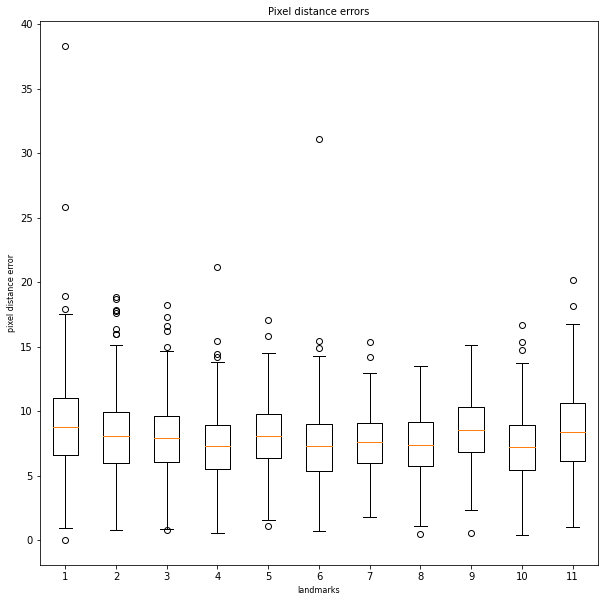

In [117]:
dataset.NoTransF()
start_time = time.time()


#best_network.cuda() 

resnet50f.eval()

predictions = torch.zeros(484, 11, 2).detach()
landmarks = torch.zeros(484, 11, 2).detach()

#images, landmarks = next(iter(test_loader))
counter = 0
with torch.no_grad():
    for images, hm, landmark_, filename in test_loader:
        #print(images.size())
        images = images.detach().reshape((1,3,224,224))
        landmark = (landmark_+0.5)*torch.tensor([1280, 1024]).detach()
        prediction = resnet50f(images)
        #print(prediction.shape)
        #prediction = get_coordinates_from_heatmap(prediction)
        #print(prediction)#*torch.tensor([1280/224, 1024/224])
        #prediction = prediction.view(-1,11,2)*torch.tensor([1280/224, 1024/224])
        
        #resize_prediction = TF.resize(prediction[0], (1280,1024))
        #print(resize_prediction.shape)

        #plt.imshow(resize_prediction[0])
        #plt.show()
        #print(images.size())
        #plt.imshow(images.reshape((1,3,1280,1024))[0][0])
       # plt.scatter(landmark[:,:,0], landmark[:,:,1])
        #plt.show()
        #print(prediction.size())
        prediction = get_average_coord(prediction[0])*torch.tensor([1280/224, 1024/224])
        #print(prediction.size())
        #print(landmark.size())
        #target = get_coordinates_from_heatmap(hm.unsqueeze(0))
        #print(target)
        #print('landmarks', landmark)
        #print('hm',get_coordinates_from_heatmap(hm.unsqueeze(0))*torch.tensor([1280/224, 1024/224]))
        #print('predictions', predictions)
        landmarks[counter,:] = landmark #get_coordinates_from_heatmap(hm.unsqueeze(0))*torch.tensor([1280/224, 1024/224])
        predictions[counter,:] = prediction[0]
        predictions.detach()
        counter += 1
endtime = time.time()-start_time
print(endtime)

#print(predictions)
difs = abs(predictions - landmarks)
difs = difs.detach()

dis = np.sqrt(difs[:, :,0]**2 + difs[:, :, 1]**2)
av = []
for I in dis:
  av.append(np.mean(I.numpy()))
print(np.mean(av))
print(np.std(av))

plt.figure(figsize=(10,10))
plt.boxplot(dis.T)

plt.xlabel('landmarks', fontsize=8)
plt.ylabel('pixel distance error', fontsize=8)
plt.title('Pixel distance errors', fontsize=10)
plt.savefig('errors_resnet50.png')
plt.show()


In [23]:
from scipy.spatial import procrustes

procrustes_errors = {'error':[], 'procrustes_disparity':[]}
for i in range(484):
    procrustes_errors['error'].append(av[i])
    mtx1, mtx2, disparity = procrustes(predictions[i], landmarks[i])
    procrustes_errors['procrustes_disparity'].append(disparity)

tensor([[14.3878, 12.7483, 10.9947,  ...,  6.9656,  9.7111,  6.2003],
        [16.0359,  8.5487,  9.4211,  ...,  8.3281, 10.3763,  8.9814],
        [ 7.5246, 14.6524, 11.0434,  ...,  8.5647,  8.5953,  8.2545],
        ...,
        [ 5.0170,  7.7241,  6.7972,  ...,  9.8578,  5.3458,  8.8546],
        [10.2576, 16.1070,  6.8460,  ...,  7.9250, 10.7813,  3.3896],
        [ 8.9416, 13.4683,  6.0289,  ...,  5.7570, 11.7957, 12.2130]])

0.19


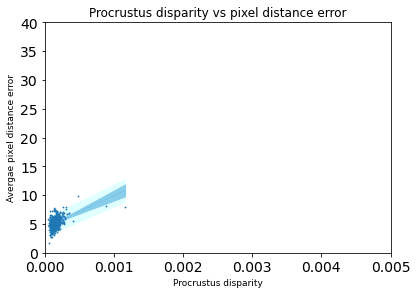

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

weights = procrustes_errors['procrustes_disparity']

heights = procrustes_errors['error']

x = weights#/max(weights)

y = heights#/max(heights)
slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment

y_model = np.polyval([slope, intercept], x)   # modeling...

x_mean = np.mean(x)
y_mean = np.mean(y)
n = len(x)                       # number of samples
m = 2                             # number of parameters
dof = n - m                       # degrees of freedom
t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

residual = y - y_model

std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

# calculating the r2
# https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
# Pearson's correlation coefficient
numerator = np.sum((x - x_mean)*(y - y_mean))
denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
correlation_coef = numerator / denominator
r2 = correlation_coef**2

# mean squared error
MSE = 1/n * np.sum( (y - y_model)**2 )

# to plot the adjusted model
x_line = np.linspace(np.min(x), np.max(x), 100)
y_line = np.polyval([slope, intercept], x_line)

# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
# predicting interval
pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  

############### Ploting
plt.rcParams.update({'font.size': 14})
fig = plt.figure()
ax = fig.add_axes([.1, .1, .8, .8])

#, 'o', color = 'royalblue')
ax.plot(x_line, y_line, color = 'royalblue', linewidth=0.1)
ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval', linewidth=0.1)
ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval')
ax.scatter(x, y, s = 0.6)
ax.set_xlabel('x')
ax.set_ylabel('y')

# rounding and position must be changed for each case and preference
a = str(np.round(intercept))
b = str(np.round(slope,2))
r2s = str(np.round(r2,2))
MSEs = str(np.round(MSE))

#ax.text(45, 110, 'y = ' + a + ' + ' + b + ' x')
#ax.text(45, 100, '$r^2$ = ' + r2s + '     MSE = ' + MSEs)
plt.title('Procrustus disparity vs pixel distance error',  fontsize=12)
plt.ylabel('Avergae pixel distance error',fontsize=9)
plt.xlabel('Procrustus disparity',fontsize=9)
#plt.plot([0,0.6],[0.38,0.38], linewidth=0.5, c='g', label = 'Median average pixel distance error')
#plt.plot([0.118,0.118],[0.0,1], linewidth=0.5, c='r', label = 'Median procrustus disparity')
#plt.legend( fontsize=8)
plt.xlim([0.0,0.005])
plt.ylim([0.0,40])
plt.savefig('linear_reg.png')
print(r2s)